# Lab 6: Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 

def load_names(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
    
    label_names = batch['label_names']
    return label_names

def load_data(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
        
    features = batch['data']
    labels = batch['labels']
    return features, labels

batch1, label1 = load_data('data_batch_1')
batch2, label2 = load_data('data_batch_2')
batch3, label3 = load_data('data_batch_3')
batch4, label4 = load_data('data_batch_4')
batch5, label5 = load_data('data_batch_5')
X_test, y_test = load_data('test_batch')
label_names = load_names('batches.meta')

#concatenating files 
X_train = np.concatenate([batch1, batch2, batch3, batch4, batch5], 0)
y_train = np.concatenate([label1, label2, label3, label4, label5], 0)
y_test = np.array(y_test)

In [2]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


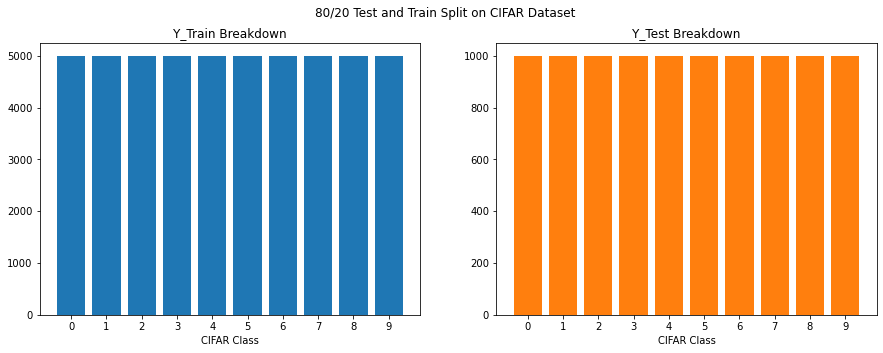

In [3]:
labels = np.arange(10)
train_labels, train_counts =  np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('80/20 Test and Train Split on CIFAR Dataset')
ax1.bar(train_labels,train_counts, color='tab:blue')
ax2.bar(test_labels,test_counts, color='tab:orange')
ax1.set_title('Y_Train Breakdown')
ax2.set_title('Y_Test Breakdown')
ax1.set_xlabel('CIFAR Class')
ax2.set_xlabel('CIFAR Class')
ax1.set_xticks(labels)
ax2.set_xticks(labels)
plt.show()

## Preparation

[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [4]:
import tensorflow as tf
from tensorflow import keras 
import sklearn
from sklearn.preprocessing import StandardScaler

## Normalizing Data and Converting to Grayscale

In [5]:
X_train = X_train.reshape((X_train.shape[0],3,32,32))
X_train = X_train.transpose(0,2,3,1)
X_test = X_test.reshape((X_test.shape[0],3,32,32))
X_test = X_test.transpose(0,2,3,1)

#X_train = np.dot(X_train,[.2989,.587,.1140])
#X_test = np.dot(X_test,[.2989,.587,.1140])

print(np.amin(X_train))
print(np.amax(X_train))

0
255


In [6]:
#scaler = StandardScaler()

X_train = X_train.reshape((X_train.shape[0],3072))
X_test = X_test.reshape((X_test.shape[0],3072))

X_train = X_train.astype('float32')/np.amax(X_train)
X_test = X_test.astype('float32')/np.amax(X_train)

#X_train = scaler.fit_transform(X_train.astype('float32'))
#X_test = scaler.transform(X_test.astype('float32'))

X_train = X_train.reshape((X_train.shape[0],32,32,3))
X_test = X_test.reshape((X_test.shape[0],32,32,3))

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
print(np.amin(X_train))
print(np.amax(X_train))

0.0
1.0


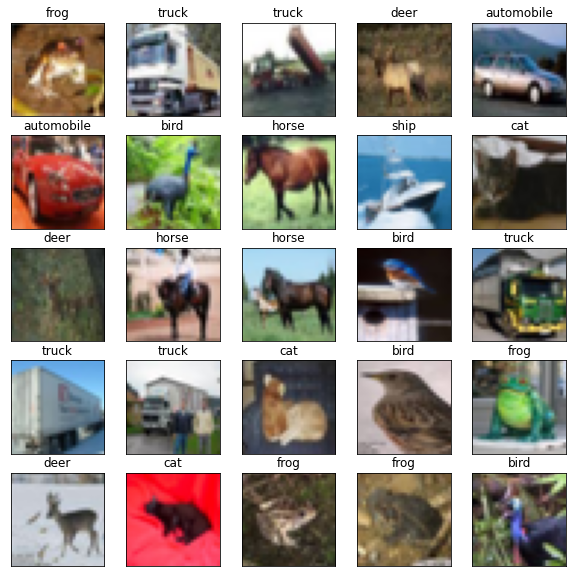

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(1,26):
    fig.add_subplot(5,5, i)
    plt.imshow(X_train[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(label_names[y_train[i-1]]))

plt.show()

## Data Expansion Using Keras

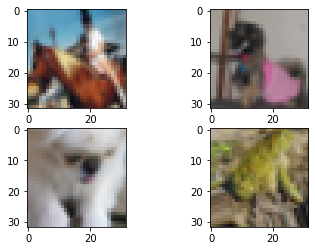

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    width_shift_range=3/32,
    height_shift_range=3/32,
    fill_mode='nearest'
    )
datagen.fit(X_train)

#Visualing augmentation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=0):
    for i in range(0,4):
        plt.subplot(220+1+i)
        plt.imshow(X_batch[i])
    plt.show()
    break

## One Hot Encoding of Target Data

In [10]:
num_classes = 10

In [11]:
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

## Multi-Layer Perceptron

In [12]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [13]:
%%time
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=200, activation='relu') )
mlp.add( Dense(units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(num_classes) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 53s 134ms/step - loss: 2.1493 - accuracy: 0.2134 - val_loss: 160.2508 - val_accuracy: 0.2950
Epoch 2/5
390/390 [==============================] - 61s 155ms/step - loss: 1.9307 - accuracy: 0.2993 - val_loss: 180.7828 - val_accuracy: 0.3273
Epoch 3/5
390/390 [==============================] - 59s 151ms/step - loss: 1.8637 - accuracy: 0.3293 - val_loss: 179.5653 - val_accuracy: 0.3511
Epoch 4/5
390/390 [==============================] - 52s 134ms/step - loss: 1.8216 - accuracy: 0.3438 - val_loss: 202.5860 - val_accuracy: 0.3528
Epoch 5/5
390/390 [==============================] - 53s 136ms/step - loss: 1.7843 - accuracy: 0.3604 - val_loss: 179.4460 - val_accuracy: 0.3787
CPU times: total: 25min 17s
Wall time: 4min 39s


In [14]:
print(X_train.shape[1:])

(32, 32, 3)


In [18]:
%%time

cnn1 = Sequential()
cnn1.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn1.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn1.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn1.add(Dropout(0.25))
cnn1.add(Flatten())
cnn1.add(Dense(128,activation='relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(num_classes))
cnn1.add(Activation('softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn1.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 54s 134ms/step - loss: 1.9306 - accuracy: 0.3033 - val_loss: 194.8873 - val_accuracy: 0.3619
Epoch 2/5
390/390 [==============================] - 59s 150ms/step - loss: 1.6539 - accuracy: 0.4061 - val_loss: 208.6654 - val_accuracy: 0.3808
Epoch 3/5
390/390 [==============================] - 57s 146ms/step - loss: 1.5604 - accuracy: 0.4424 - val_loss: 235.7793 - val_accuracy: 0.3420
Epoch 4/5
390/390 [==============================] - 59s 150ms/step - loss: 1.4981 - accuracy: 0.4648 - val_loss: 179.4330 - val_accuracy: 0.3921
Epoch 5/5
390/390 [==============================] - 66s 168ms/step - loss: 1.4569 - accuracy: 0.4790 - val_loss: 240.6618 - val_accuracy: 0.3513
CPU times: total: 33min 7s
Wall time: 4min 54s


In [19]:
%%time

cnn1 = Sequential()
cnn1.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn1.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn1.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn1.add(Dropout(0.25))
cnn1.add(Flatten())
cnn1.add(Dense(128,activation='relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(num_classes))
cnn1.add(Activation('softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn1.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 101s 253ms/step - loss: 1.8360 - accuracy: 0.3399 - val_loss: 200.0944 - val_accuracy: 0.3785
Epoch 2/5
390/390 [==============================] - 102s 260ms/step - loss: 1.5487 - accuracy: 0.4486 - val_loss: 222.4677 - val_accuracy: 0.3939
Epoch 3/5
390/390 [==============================] - 101s 258ms/step - loss: 1.4486 - accuracy: 0.4855 - val_loss: 158.0616 - val_accuracy: 0.4550
Epoch 4/5
390/390 [==============================] - 99s 253ms/step - loss: 1.3929 - accuracy: 0.5067 - val_loss: 177.5091 - val_accuracy: 0.4536
Epoch 5/5
390/390 [==============================] - 103s 263ms/step - loss: 1.3593 - accuracy: 0.5216 - val_loss: 169.8613 - val_accuracy: 0.4529
CPU times: total: 56min 16s
Wall time: 8min 25s


In [22]:
%%time

cnn2 = Sequential()
cnn2.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn2.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn2.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn2.add(Dropout(0.25))
cnn2.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn2.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn2.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn2.add(Dropout(0.25))
cnn2.add(Flatten())
cnn2.add(Dense(128,activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(num_classes))
cnn2.add(Activation('softmax'))

cnn2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn2.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 93s 233ms/step - loss: 1.9563 - accuracy: 0.2884 - val_loss: 237.7014 - val_accuracy: 0.2853
Epoch 2/5
390/390 [==============================] - 99s 252ms/step - loss: 1.6469 - accuracy: 0.4084 - val_loss: 219.0252 - val_accuracy: 0.2836
Epoch 3/5
390/390 [==============================] - 107s 274ms/step - loss: 1.5214 - accuracy: 0.4563 - val_loss: 208.9962 - val_accuracy: 0.3382
Epoch 4/5
390/390 [==============================] - 110s 282ms/step - loss: 1.4366 - accuracy: 0.4887 - val_loss: 206.9053 - val_accuracy: 0.3144
Epoch 5/5
390/390 [==============================] - 110s 281ms/step - loss: 1.3737 - accuracy: 0.5113 - val_loss: 139.9312 - val_accuracy: 0.3215
CPU times: total: 58min 34s
Wall time: 8min 39s


In [23]:
%%time

cnn3 = Sequential()
cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn3.add(Dropout(0.25))
cnn3.add(Conv2D(filters=128,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=128,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn3.add(Dropout(0.25))
cnn3.add(Flatten())
cnn3.add(Dense(128,activation='relu'))
cnn3.add(Dropout(0.5))
cnn3.add(Dense(num_classes))
cnn3.add(Activation('softmax'))

cnn3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn3.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 231s 587ms/step - loss: 1.9293 - accuracy: 0.2984 - val_loss: 108.2258 - val_accuracy: 0.3689
Epoch 2/5
390/390 [==============================] - 225s 576ms/step - loss: 1.5850 - accuracy: 0.4312 - val_loss: 195.7563 - val_accuracy: 0.2641
Epoch 3/5
390/390 [==============================] - 226s 578ms/step - loss: 1.4411 - accuracy: 0.4911 - val_loss: 138.2088 - val_accuracy: 0.2832
Epoch 4/5
390/390 [==============================] - 217s 555ms/step - loss: 1.3331 - accuracy: 0.5258 - val_loss: 131.7661 - val_accuracy: 0.3878
Epoch 5/5
390/390 [==============================] - 220s 563ms/step - loss: 1.2470 - accuracy: 0.5619 - val_loss: 168.0809 - val_accuracy: 0.3357
CPU times: total: 2h 3min 59s
Wall time: 18min 38s


[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

[1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

[1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 